In [ ]:
!pip -q install tensorflow=="2.4"
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools

     |████████████████████████████████| 394.7 MB 16 kB/s 
     |████████████████████████████████| 2.9 MB 34.7 MB/s 
     |████████████████████████████████| 3.8 MB 36.0 MB/s 
     |████████████████████████████████| 462 kB 44.4 MB/s 
     |████████████████████████████████| 591 kB 5.4 MB/s 
     |████████████████████████████████| 6.3 MB 33.8 MB/s 
     |████████████████████████████████| 87 kB 7.0 MB/s 
     |████████████████████████████████| 1.1 MB 41.6 MB/s 
     |████████████████████████████████| 1.2 MB 36.4 MB/s 
     |████████████████████████████████| 120 kB 46.0 MB/s 
     |████████████████████████████████| 840 kB 29.2 MB/s 
     |████████████████████████████████| 596 kB 34.9 MB/s 
     |████████████████████████████████| 103 kB 46.3 MB/s 
     |████████████████████████████████| 213 kB 29.5 MB/s 
     |████████████████████████████████| 1.1 MB 33.1 MB/s 
     |████████████████████████████████| 64 kB 3.4 MB/s 
     |████████████████████████████████| 207 kB 33.0 MB/s 
     |█████████████

In [ ]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')
print(tf.__version__)

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

2.4.0


In [ ]:
!curl -L "https://app.roboflow.com/ds/MRtJOCvWpY?key=v5dj2YEsFa" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
!mkdir /content/test/images
!mkdir /content/test/annotations
!mkdir /content/train/images
!mkdir /content/train/annotations
!mkdir /content/valid/images
!mkdir /content/valid/annotations
!mv /content/test/*.jpg /content/test/images
!mv /content/test/*.xml /content/test/annotations
!mv /content/train/*.jpg /content/train/images
!mv /content/train/*.xml /content/train/annotations
!mv /content/valid/*.jpg /content/valid/images
!mv /content/valid/*.xml /content/valid/annotations

In [ ]:
test_data = object_detector.DataLoader.from_pascal_voc(
    "/content/test/images",
    "/content/test/annotations",
    label_map={1: "masked", 2: "unmasked"}) 

In [ ]:
#Funzioni per ottenere le coordinate dei "Bounding boxes", scores, predizioni sulle classi
import cv2

from PIL import Image

model_path = 'detect.tflite'


classes = ['???'] * 2


classes[0] = 'Masked'
classes[1] = 'Unmasked'

COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Effettua il preprocessing dell'immagine che la rete dovrà elaborare"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Imposta il tensore di input."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Ritorna il tensore di output ad un dato indice """
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor

#FUNZIONE CHE EFFETTUA LA PREDIZIONE SULL'IMMAGINE

def detect_objects(interpreter, image, threshold):
  """Ritorna una lista dei riconoscimenti, per ognuno un dizionario contenete le informazioni della predizione."""
  # Da come input al modello l'immagine
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  #Prende tutti gli output dal modello
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results

#Richiama la funzione precedente su ogni immagine
def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Carica l'immagine e ne effettua il preprocessing
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Esegue il riconoscimento sull'immagine
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)
  if (len(results) == 0):
    FN = FN + 1
  # Traccia i risultati del riconoscimento sull'immagine di input
  original_image_np = original_image.numpy().astype(np.uint8)
  bbC = []
  scoreArr = []
  classLabels = []
  for obj in results:
    bb=[]
    # Converte le coordinate del bounding box da relative a assolute in base alla risoluzione originale dell'immagine

    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])
    bb.append(xmin)
    bb.append(xmax)
    bb.append(ymin)
    bb.append(ymax)

    bbC.append(bb)
    scoreArr.append(obj['score'])
    classLabels.append(int(obj['class_id']))
    # Disegna il bounding box e scrive l'etichetta sull'immagine
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Fa degli aggiustamenti per rendere visibile l'etichetta sull'immagine
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Ritorna l'immagine finale
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8,bbC,scoreArr,classLabels

In [ ]:
# Funzione utilizzata per il calcolo dell'Intersection over Union (IoU)
# Calcola quindi l'intersezione tra il rettangolo predetto e il rettangolo "vero" e l'unione tra i due e ne effettua la divisione per ottenre l'indice:
# Intersection Over Union (iOU)
def compute_iou(g_xmin,g_xmax,g_ymin,g_ymax, d_xmin,d_xmax,d_ymin,d_ymax):
   
    
    xa = max(g_xmin, d_xmin)
    ya = max(g_ymin, d_ymin)
    xb = min(g_xmax, d_xmax)
    yb = min(g_ymax, d_ymax)

    intersection = max(0, xb - xa) * max(0, yb - ya)

    boxAArea = (g_xmax - g_xmin) * (g_ymax - g_ymin)
    boxBArea = (d_xmax - d_xmin) * (d_ymax - d_ymin)

    return intersection / float(boxAArea + boxBArea - intersection)


In [ ]:
# 0 ---> masked
# 1 ---> unmasked
# GROUNDTRUTH_BOX contiene le coordinate dei valori veri (x_min,x_max,y_min,y_max) dei bounding_box del dataset di test
# label_truth contiene le classi delle immagini del dataset di test: 0 --> MASKED, 1 ---> UNMASKED
groundtruth_box = [[104,262,40,368],[162,370,55,244],[49,348,34,365],
                   [172,346,33,381],[204,307,48,264],[56,352,29,327],[140,270,67,285],
                   [86,198,87,253],[200,378,75,252],[54,311,93,324],
                   [107,279,54,376],[10,278,91,341],[53,322,44,403],
                   [97,351,43,362],[68,325,96,387],[118,301,58,316],
                   [70,332,30,319],[106,274,46,298],[127,281,41,247],
                   [148,347,68,317],[97,322,23,310],[1,296,17,249],[108,326,50,350],
                   [157,302,55,307],[154,257,32,276],[81,224,94,264],[140,273,39,300],
                   [95,251,103,347],[31,371,33,416],[21,370,12,385],
                   [113,351,26,346],[64,363,28,288],[21,286,13,276],
                   [119,318,28,264],[66,373,16,380],[2,241,23,211],
                   [131,340,18,317],[101,308,19,246],[63,416,15,301],
                   [48,323,26,366],[33,319,65,416],[112,266,71,365],
                   [29,309,13,263],[56,366,23,369],[67,364,19,386],
                   [56,360,20,383],[100,307,35,355],[54,271,58,291],
                   [88,294,59,416],[8,315,22,416],[9,377,23,416],
                   [23,366,44,411],[13,388,47,408],[38,338,37,416],
                   [47,339,23,384],[79,328,39,397],[42,330,37,416],
                   [26,361,34,376],[48,337,48,401],[42,370,55,390],
                   [24,394,16,415],[23,378,51,400],[73,355,42,397],
                   [50,365,55,408],[35,342,36,426],[11,367,39,403],
                   [40,398,48,403],[42,334,39,402],[28,352,44,412],
                   [47,345,6,375],[49,353,29,407],[12,358,19,410],
                   [47,386,17,417],[54,340,56,406],[30,345,38,399],
                   [27,335,65,400],[61,384,55,413],[49,357,45,406],
                   [68,342,48,403],[51,321,78,396],[43,333,38,416],
                   [19,335,38,416],[44,331,69,395],[43,391,62,402],
                   [51,364,30,387],[14,362,32,416],[34,351,39,404],
                   [37,341,34,391],[26,393,48,387],[29,388,34,408],
                   [44,328,31,389],[38,365,17,387],[37,364,37,400],
                   [61,361,29,388],[37,346,35,410],[30,346,51,393],
                   [40,368,28,381],[52,389,30,416],[26,340,39,416],
                   [9,416,28,417]]
label_truth = [0,0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,0,
               0,0,0,0,0,0,0,0,0,0,
               1,1,1,1,1,1,1,1,1,1,
               1,1,1,1,1,1,1,1,1,1,
               1,1,1,1,1,1,1,1,1,1,
               1,1,1,1,1,1,1,1,1,1,
               1,1,1,1,1,1,1,1,1,1
               ]



In [ ]:
# detection box trattiene le coordinate dei bounding boxes delle predizioni sulle immagini.
# scores rappresenta i valori dei punteggi assegnati ad ogni predizione
# label_pred trattiene le predizioni delle classi 0 --->MASKED, 1 ---> UNMASKED 
detection_box = [];
scores = [];
label_pred = [];
DETECTION_THRESHOLD = 0.3
FN = 0
import os
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Raccogli i dati iterando la cartella test
for filename in sorted(os.listdir('/content/test/images/')):
    print(filename)
    path = '/content/test/images/'+filename
    detection_result_image,bb,score,classL = run_odt_and_draw_results(
      path,
      interpreter,
      threshold=DETECTION_THRESHOLD)
    detection_box.append(bb)
    scores.append(score)
    label_pred.append(classL)

In [ ]:
# LOGICA PER IL CALCOLO DI TRUE POSITIVE, TRUE NEGATIVE, FALSE POSITIVE E FALSE NEGATIVE
# Se l'indice è al di sotto della soglia THRESHOLD allora la predizione è False Positive
# Se l'indice supera la soglia ma la predizione è sbagliata allora la predizione è False Negative. Anche la soglia di probabilità deve essere maggiore di una certa soglia.
# Se l'indice supera la soglia e la predizione è  corretta allora la predizione è True Positive. Anche la soglia di probabilità deve essere maggiore di una certa soglia.

falsePositive = []
wrongClass = []

# Non considero i True Negative in quanto utilizzo immagini dove è sempre presente l'immagine di interesse
# La logica  dell'algoritmo è adattata al dataset in cui in ogni immagine è presente un solo soggetto con mascherina
THRESHOLD = 0.5
SCORETHRESOLD = 0.5
tp = 0;
fp = 0;
fn = 0;
tn = 0;
for i in range(100):
  lunghezza = range(len(detection_box[i]))
  
  for j in lunghezza:
    iOU = compute_iou(detection_box[i][j][0],detection_box[i][j][1],detection_box[i][j][2],detection_box[i][j][3],
                    groundtruth_box[i][0],groundtruth_box[i][1],groundtruth_box[i][2],groundtruth_box[i][3])
  
  if iOU > THRESHOLD and scores[i][0] > SCORETHRESOLD and label_pred[i][j] == label_truth[i]: 
      tp = tp + 1
  elif iOU > THRESHOLD and scores[i][0] > SCORETHRESOLD and label_pred[i][j] != label_truth[i]:
      fn = fn +1
      wrongClass.append(label_pred[i][j])
  elif iOU < THRESHOLD:
      falsePositive.append(label_pred[i][j])
      fp = fp +1
      

In [ ]:
print(tp)
print(fp)
print(fn)
# wrongClass contiene le predizioni sbagliate, ad esempio: ha predetto masked(0) ma era unmasked (1)
print(wrongClass)
# falsePositive: contiene le predizioni fatte dove non c'era nulla da classificare, ad esempio ha predetto masked(0) ma non c'era nulla (FP)
print(falsePositive)

98
1
1
[0]
[0]


In [ ]:
# PARAMETRI PRESTAZIONALI
sensitivity = tp/(tp + fn)
precision = tp/(tp + fp)
accuracy = (tp + tn)/(tp+fp+tn+fn)


print('La precisione è: ', precision)
print('La sensitività è: ' , sensitivity)
print('La accuratezza è: ' , accuracy)



La specificità è:  0.0
La precisione è:  0.98989898989899
La sensitività è:  0.98989898989899
La accuratezza è:  0.98


Text(0.5, 29.5, 'Valori Predetti')

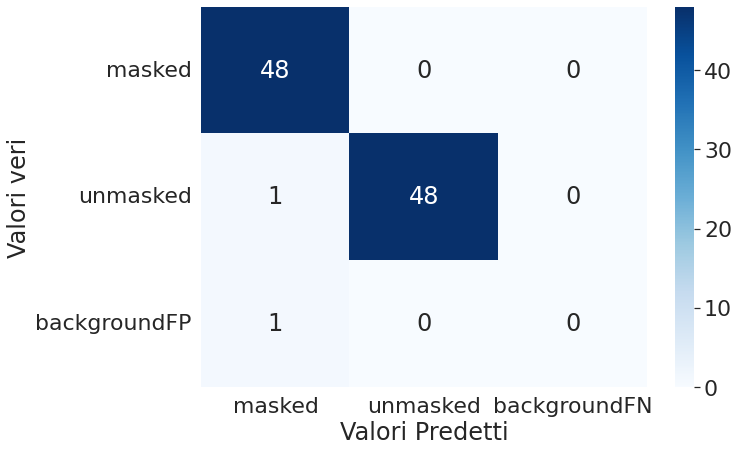

In [ ]:
# GENERAZIONE MATRICE DI CONFUSIONE
# Se l'algoritmo ha fatto una predizione in una zona dove non c'era nulla allora questa verrà considerata nell'ultima riga della matrice (in corrispondenza della colonna della classe predetta (masked/unmasked)
# Se l'algoritmo non riconosce una zona di interesse dove invece è presente l'oggetto di interesse questa verrà considerata nell'ultima colonna (in corrispondenza della classe che sarebbe dovuta essere predetta)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[48,0,0],[1,48,0],[1,0,0]]
df_cm = pd.DataFrame(array, index = ["masked","unmasked","backgroundFP"],
                  columns = ["masked","unmasked","backgroundFN"])
plt.figure(figsize = (10,7))

sn.set(font_scale=2)

sn.heatmap(df_cm, annot=True,cmap="Blues")
plt.ylabel('Valori veri')
plt.xlabel('Valori Predetti')